# Steps
1. Import train of persistent and non-persistent
2. Combine benign
3. Combine threats
4. Rename threats as malicious
5. Train model
6. Import testing data 
7. Process test data in same way to combine benign and malicious
8. Run testing
9. Export model

In [2]:
cic_ids_features = ['src_port',
 'dst_port',
 'src2dst_packets',
 'dst2src_packets',
 'src2dst_bytes',
 'dst2src_bytes',
 'src2dst_duration_ms',
 'dst2src_duration_ms',
 'src2dst_rst_packets',
 'dst2src_rst_packets',
 'protocol',
 'bidirectional_duration_ms',
 'bidirectional_min_ps',
 'bidirectional_max_ps',
 'bidirectional_mean_ps',
 'bidirectional_stddev_ps',
 'src2dst_max_ps',
 'src2dst_min_ps',
 'src2dst_mean_ps',
 'src2dst_stddev_ps',
 'dst2src_max_ps',
 'dst2src_min_ps',
 'dst2src_mean_ps',
 'dst2src_stddev_ps',
 'bidirectional_mean_piat_ms',
 'bidirectional_stddev_piat_ms',
 'bidirectional_max_piat_ms',
 'bidirectional_min_piat_ms',
 'src2dst_mean_piat_ms',
 'src2dst_stddev_piat_ms',
 'src2dst_max_piat_ms',
 'src2dst_min_piat_ms',
 'dst2src_mean_piat_ms',
 'dst2src_stddev_piat_ms',
 'dst2src_max_piat_ms',
 'dst2src_min_piat_ms',
 'bidirectional_fin_packets',
 'bidirectional_syn_packets',
 'bidirectional_rst_packets',
 'bidirectional_psh_packets',
 'bidirectional_ack_packets',
 'bidirectional_urg_packets',
 'bidirectional_cwr_packets',
 'bidirectional_ece_packets',
 'src2dst_psh_packets',
 'dst2src_psh_packets',
 'src2dst_urg_packets',
 'dst2src_urg_packets',
 'Label']

# Imports

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\zac\miniconda3\envs\navya\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import training for persistent and non persistent

In [4]:
unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')
cic_ids = pd.read_csv('TRAIN_DFs/cic_ids_2017_train.csv')
persistent_testbed = pd.read_csv('TRAIN_DFs/persistent_testbed_train.csv')
non_persistent_testbed = pd.read_csv('TRAIN_DFs/non_persistent_testbed_train.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_12896\1923406082.py:1: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')


In [5]:
unused = ['Infiltration - Portscan', 'Portscan']
cic_ids = cic_ids.loc[~cic_ids['Label'].isin(unused)]
cic_ids['Label'] = cic_ids['Label'].replace('BENIGN', 'Benign')

# Create combined benign dataset and rename label to benign

In [6]:
benign_training = pd.DataFrame()
malicious_training = pd.DataFrame()

benign_training = pd.concat([benign_training, unraveled[unraveled['Label'] == 'Benign'].copy(), cic_ids[cic_ids['Label'] == 'Benign'].copy()])
malicious_training = pd.concat([unraveled[unraveled['Label'] != 'Benign'].copy(), cic_ids[cic_ids['Label'] != 'Benign'].copy()])
malicious_training['Label'] = 'malicious'

# testbed data has no benign samples
malicious_training_testbed = pd.concat([persistent_testbed, non_persistent_testbed])
malicious_training_testbed['Label'] = 'malicious'


# Testing Datasets

In [7]:
cic_ids_test = pd.read_csv('TEST_DFs/cic_ids_2017_test.csv')
non_persistent_testbed_test = pd.read_csv('TEST_DFs/non_persistent_testbed_test.csv')
persistent_testbed_test = pd.read_csv('TEST_DFs/persistent_testbed_test.csv')
unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_12896\1948669035.py:4: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')


In [8]:
unused = ['Infiltration - Portscan', 'Portscan']
cic_ids_test = cic_ids_test.loc[~cic_ids_test['Label'].isin(unused)]
cic_ids_test['Label'] = cic_ids_test['Label'].replace('BENIGN', 'Benign')

In [9]:
benign_testing = pd.DataFrame()
malicious_testing = pd.DataFrame()

benign_testing = pd.concat([benign_testing, unraveled_test[unraveled_test['Label'] == 'Benign'].copy(), cic_ids_test[cic_ids_test['Label'] == 'Benign'].copy()])
malicious_testing = pd.concat([unraveled_test[unraveled_test['Label'] != 'Benign'].copy(), cic_ids_test[cic_ids_test['Label'] != 'Benign'].copy()])
malicious_testing['Label'] = 'malicious'

# testbed data has no benign samples
malicious_testing_testbed = pd.concat([persistent_testbed_test, non_persistent_testbed_test])
malicious_testing_testbed['Label'] = 'malicious'


In [10]:
benign_unraveled = pd.read_csv('unraveled_benign.csv')
benign_cic_ids = pd.read_csv('cic_ids_benign.csv')

In [19]:
benign_cic_ids['Label'] = benign_cic_ids['Label'].replace('BENIGN', 'Benign')

# Train model

In [ ]:
results = pd.DataFrame(columns=['train_rows', 'mcc_cic_unraveled', 'mcc_combined', 'best_model'])

for train_rows in range(10000, 80000, 10000):
    combined_train_df = pd.concat([benign_unraveled[:train_rows], benign_cic_ids[:train_rows], malicious_training[:train_rows], malicious_training_testbed[:train_rows]])
    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df[cic_ids_features], presets='medium', fit_weighted_ensemble=False, included_model_types=['GBM', 'XGB', 'FASTAI', 'RF', 'XT', 'KNN'])

    cic_unraveled_test = pd.concat([benign_testing, malicious_testing[cic_ids_features]])
    combined_test = pd.concat([cic_unraveled_test, malicious_testing_testbed[cic_ids_features]])


    cic_unreaveled_results = predictor.evaluate(cic_unraveled_test[cic_ids_features])
    combined_results = predictor.evaluate(combined_test[cic_ids_features])
    combined_leaderboard = predictor.leaderboard(combined_test[cic_ids_features])


    new_row = {'train_rows': train_rows, 'mcc_combined':combined_results['mcc'], 'mcc_cic_unraveled':cic_unreaveled_results['mcc'], 'best_model': combined_leaderboard.iloc[0]['model']}

    print(new_row)

    results.loc[len(results)] = new_row

No path specified. Models will be saved in: "AutogluonModels\ag-20250716_043727"


Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       41.31 GB / 63.72 GB (64.8%)
Disk Space Avail:   463.34 GB / 1906.98 GB (24.3%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250716_043727"
Train Data Rows:    40000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['Benign', 'malicious']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'r

{'train_rows': 10000, 'mcc_combined': np.float64(0.6166377350676939), 'mcc_cic_unraveled': np.float64(0.6415104865081158), 'best_model': 'ExtraTreesEntr'}


		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Unused Original Features (Count: 4): ['bidirectional_cwr_packets', 'bidirectional_ece_packets', 'src2dst_urg_packets', 'dst2src_urg_packets']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 4 | ['bidirectional_cwr_packets', 'bidirectional_ece_packets', 'src2dst_urg_packets', 'dst2src_

{'train_rows': 20000, 'mcc_combined': np.float64(0.9534265786926088), 'mcc_cic_unraveled': np.float64(0.9485678706509876), 'best_model': 'XGBoost'}


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Unused Original Features (Count: 4): ['bidirectional_cwr_packets', 'bidirectional_ece_packets', 'src2dst_urg_packets', 'dst2src_urg_packets']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 4 | ['bidirectional_cwr_packets', 'bidirectional_ece_packets', 'src2dst_ur

{'train_rows': 30000, 'mcc_combined': np.float64(0.9417287796729334), 'mcc_cic_unraveled': np.float64(0.9356079563434245), 'best_model': 'ExtraTreesEntr'}


	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (malicious) vs negative (Benign) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    42116.99 MB
	Train Data (Original)  Memory Usage: 53.75 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerat

{'train_rows': 40000, 'mcc_combined': np.float64(0.956230370652941), 'mcc_cic_unraveled': np.float64(0.9510824181284743), 'best_model': 'ExtraTreesEntr'}


	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (malicious) vs negative (Benign) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    42006.90 MB
	Train Data (Original)  Memory Usage: 61.08 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerat

{'train_rows': 50000, 'mcc_combined': np.float64(0.9435517748734021), 'mcc_cic_unraveled': np.float64(0.9407007408235261), 'best_model': 'ExtraTreesEntr'}


Selected class <--> label mapping:  class 1 = malicious, class 0 = Benign
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (malicious) vs negative (Benign) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    41901.45 MB
	Train Data (Original)  Memory Usage: 68.40 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatu

{'train_rows': 60000, 'mcc_combined': np.float64(0.954970490615981), 'mcc_cic_unraveled': np.float64(0.9493725236608207), 'best_model': 'LightGBM'}


	2 unique label values:  ['Benign', 'malicious']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = malicious, class 0 = Benign
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (malicious) vs negative (Benign) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    41859.17 MB
	Train Data (Original)  Memory Usage: 75.73 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the feat

{'train_rows': 70000, 'mcc_combined': np.float64(0.9446983539079173), 'mcc_cic_unraveled': np.float64(0.9396136131690624), 'best_model': 'LightGBM'}


In [25]:
results

,train_rows,mcc_cic_unraveled,mcc_combined,best_model
0,10000,0.641510,0.616638,ExtraTreesEntr
1,20000,0.948568,0.953427,XGBoost
2,30000,0.935608,0.941729,ExtraTreesEntr
3,40000,0.951082,0.956230,ExtraTreesEntr
4,50000,0.940701,0.943552,ExtraTreesEntr
5,60000,0.949373,0.954970,LightGBM
6,70000,0.939614,0.944698,LightGBM


<Axes: xlabel='train_rows', ylabel='value'>

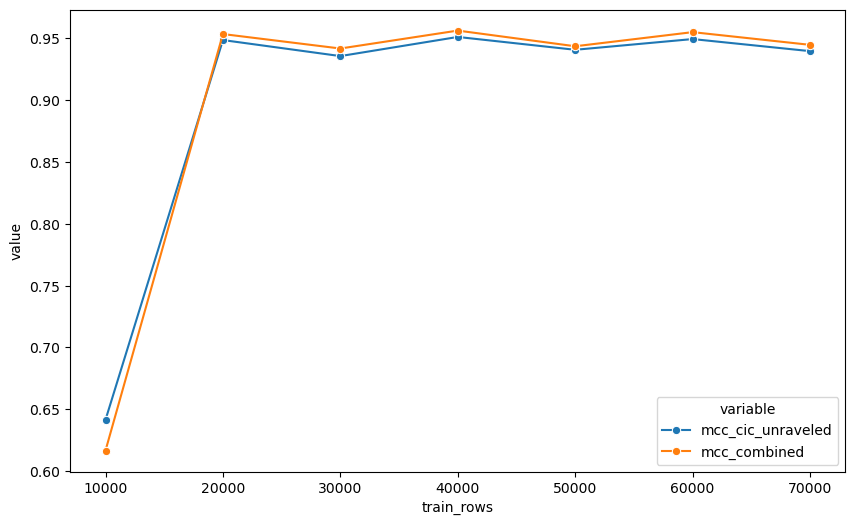

In [27]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = results.melt(id_vars='train_rows',
                          value_vars=['mcc_cic_unraveled', 'mcc_combined'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='train_rows', y='value', hue='variable', marker='o')

In [29]:
train_rows = 20000

combined_train_df = pd.concat([benign_unraveled[:train_rows], benign_cic_ids[:train_rows], malicious_training[:train_rows], malicious_training_testbed[:train_rows]])

predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df[cic_ids_features], presets='medium', fit_weighted_ensemble=False, included_model_types=['GBM', 'XGB','RF', 'XT', 'KNN'])


No path specified. Models will be saved in: "AutogluonModels\ag-20250716_060356"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       42.43 GB / 63.72 GB (66.6%)
Disk Space Avail:   461.26 GB / 1906.98 GB (24.2%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250716_060356"
Train Data Rows:    80000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['Benign', 'malicious']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Pr

In [30]:
cic_unraveled_test = pd.concat([benign_testing, malicious_testing[cic_ids_features]])
combined_test = pd.concat([cic_unraveled_test, malicious_testing_testbed[cic_ids_features]])


cic_unreaveled_results = predictor.evaluate(cic_unraveled_test[cic_ids_features])
combined_results = predictor.evaluate(combined_test[cic_ids_features])
combined_leaderboard = predictor.leaderboard(combined_test[cic_ids_features])


In [33]:
combined_leaderboard

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.958232,0.996000,mcc,0.077788,0.009061,0.850473,0.077788,0.009061,0.850473,1,True,9
1,LightGBM,0.955285,0.996000,mcc,0.021925,0.006066,0.985649,0.021925,0.006066,0.985649,1,True,4
2,ExtraTreesEntr,0.953427,0.996801,mcc,0.110093,0.040683,0.865303,0.110093,0.040683,0.865303,1,True,8
3,RandomForestGini,0.942701,0.996000,mcc,0.105625,0.040812,1.264807,0.105625,0.040812,1.264807,1,True,5
4,LightGBMXT,0.939523,0.992001,mcc,0.036690,0.007255,1.231192,0.036690,0.007255,1.231192,1,True,3
5,ExtraTreesGini,0.937784,0.996801,mcc,0.118161,0.041689,0.853782,0.118161,0.041689,0.853782,1,True,7
6,RandomForestEntr,0.936869,0.995201,mcc,0.098348,0.041366,1.255015,0.098348,0.041366,1.255015,1,True,6
7,LightGBMLarge,0.928149,0.991200,mcc,0.016143,0.006037,0.582855,0.016143,0.006037,0.582855,1,True,10
8,KNeighborsDist,0.914460,0.953678,mcc,0.657782,0.053026,0.094763,0.657782,0.053026,0.094763,1,True,2
9,KNeighborsUnif,0.903887,0.948878,mcc,0.704736,0.074919,0.074557,0.704736,0.074919,0.074557,1,True,1


In [35]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='benign_malicious_model_finetune', model='XGBoost')

Cloned TabularPredictor located in 'c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250716_060356' to 'benign_malicious_model_finetune'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="benign_malicious_model_finetune")
Clone: Keeping minimum set of models required to predict with model 'XGBoost'...
Deleting model KNeighborsUnif. All files under c:\Users\zac\Documents\github\modular_ids_framework\benign_malicious_model_finetune\models\KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under c:\Users\zac\Documents\github\modular_ids_framework\benign_malicious_model_finetune\models\KNeighborsDist will be removed.
Deleting model LightGBMXT. All files under c:\Users\zac\Documents\github\modular_ids_framework\benign_malicious_model_finetune\models\LightGBMXT will be removed.
Deleting model LightGBM. All files under c:\Users\zac\Documents\github\modular_ids_framework\benign_malicious_model_finetune\models\LightGBM wil